#Set up working directory

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
# !cp drive/MyDrive/MMDS-data/spark-3.1.1-bin-hadoop3.2.tgz .
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

import os
import shutil
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

!pip install pyspark

import findspark
findspark.init()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# Import Library

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, when, explode
import pyspark.sql.functions as F
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler,StringIndexer
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import monotonically_increasing_id
import matplotlib.pyplot as plt
from pyspark.sql.types import DoubleType, IntegerType
import numpy as np
from pyspark.ml.linalg import Vectors

## File Path

In [ ]:
# mnist_data_path = "/content/mnist_mini.csv"
# rating_data_path = "/content/ratings2k.csv"
# stock_data_path = "/content/stockHVN2022.csv"

mnist_data_path = "./drive/MyDrive/BigData_Final/datasets/mnist_mini.csv"
rating_data_path = "./drive/MyDrive/BigData_Final/datasets/ratings2k.csv"
stock_data_path = "./drive/MyDrive/BigData_Final/datasets/stockHVN2022.csv"

# CÂU 1

In [ ]:
class ClusteringWithKMeans:
  def __init__(self,filepath, spark=None,  k=10, weighted_rows=[0, 1, 2, 3, 4, 7, 8, 11, 18, 61]):
        self.spark = spark or SparkSession.builder.appName("KMeans Clustering").getOrCreate()
        self.k = k
        self.weighted_rows = weighted_rows
        self.filepath = filepath

  def load_data(self, file_path):
        # Load data into DataFrame
        data = self.spark.read.csv(file_path, header=False, inferSchema=True)
        num_columns = len(data.columns)
        # Rename columns dynamically
        columns = ["label"] + [f"pixel_{i}" for i in range(1, num_columns)]
        data = data.toDF(*columns)
        return data

  def preprocess_data(self, df):
      # Combine features into a single column
      assembler = VectorAssembler(inputCols=df.columns[1:], outputCol="features")
      df = assembler.transform(df)
      scale=StandardScaler(inputCol='features',outputCol='standardized',withStd=True,
                      withMean=False)
      data_scale=scale.fit(df)
      data_scale_output=data_scale.transform(df)

      return data_scale_output

  def weight_data(self, data):
      # Assign weights to specified rows
      data = data.withColumn("index", F.monotonically_increasing_id())
      # Gán trọng số dựa trên chỉ số dòng
      weighted_data = data.withColumn("weight", when(data.index.isin(self.weighted_rows), 100).otherwise(1))
      # Loại bỏ cột 'index' nếu không cần thiết
      weighted_data = weighted_data.drop("index")
      return weighted_data.select("label", "standardized", "weight")

  def Handle_KMeans(self, data):
      kmeans = KMeans(featuresCol="standardized", k=self.k, weightCol="weight",seed=42, initMode="k-means||", distanceMeasure="euclidean")
      model = kmeans.fit(data)
      # Make predictions
      predictions = model.transform(data)
      return predictions, model


  def calculate_distances_to_centroids(self, predictions, model):
        # Get cluster centroids from the KMeans model
        centroids = model.clusterCenters()

        # Extract features (standardized) and prediction (cluster label) columns
        predictions = predictions.select("prediction", "standardized")

        # Define a UDF to calculate Euclidean distance between vectors
        euclidean_distance = F.udf(lambda x, y: float(Vectors.dense(x).squared_distance(Vectors.dense(y))), returnType=DoubleType())

        # Calculate distances from each data point to the centroid of its cluster
        distances = predictions.withColumn("distance", euclidean_distance("standardized", F.array([F.lit(c) for c in centroids[0]])))

        # Calculate average distance for each cluster
        cluster_distances = distances.groupBy("prediction").agg(F.avg("distance").alias("avg_distance"))

        return cluster_distances

  def visualize_cluster_distances(self, cluster_distances):
    # Get data from DataFrame
      clusters = cluster_distances.select("prediction").rdd.flatMap(lambda x: x).collect()
      avg_distances = cluster_distances.select("avg_distance").rdd.flatMap(lambda x: x).collect()

      # Plot bar chart
      plt.figure(figsize=(10, 10))
      plt.bar(clusters, avg_distances, color='blue')
      plt.xlabel('Cluster')
      plt.ylabel('Average Distance to Centroid')
      plt.title('Average Distance to Centroid for Each Cluster')
      for i in range(len(clusters)):
        plt.text(clusters[i], avg_distances[i], f'{avg_distances[i]:.2f}', ha='center', va='bottom')
      plt.show()

  def run(self):
    data_file = self.load_data(self.filepath)
    preprocess_data = self.preprocess_data(data_file)
    weight_data = self.weight_data(preprocess_data)
    predictions, model = self.Handle_KMeans(weight_data)
    predictions.show(10)
    cluster_distances = self.calculate_distances_to_centroids(predictions, model)
    # cluster_distances.show()
    self.visualize_cluster_distances(cluster_distances)


+-----+--------------------+------+----------+
|label|        standardized|weight|prediction|
+-----+--------------------+------+----------+
|    7|(784,[202,203,204...|   100|         2|
|    2|(784,[94,95,96,97...|   100|         9|
|    1|(784,[128,129,130...|   100|         8|
|    0|(784,[124,125,126...|   100|         0|
|    4|(784,[150,151,159...|   100|         2|
|    1|(784,[156,157,158...|     1|         8|
|    4|(784,[149,150,151...|     1|         2|
|    9|(784,[179,180,181...|   100|         8|
|    5|(784,[129,130,131...|   100|         7|
|    9|(784,[209,210,211...|     1|         2|
+-----+--------------------+------+----------+
only showing top 10 rows



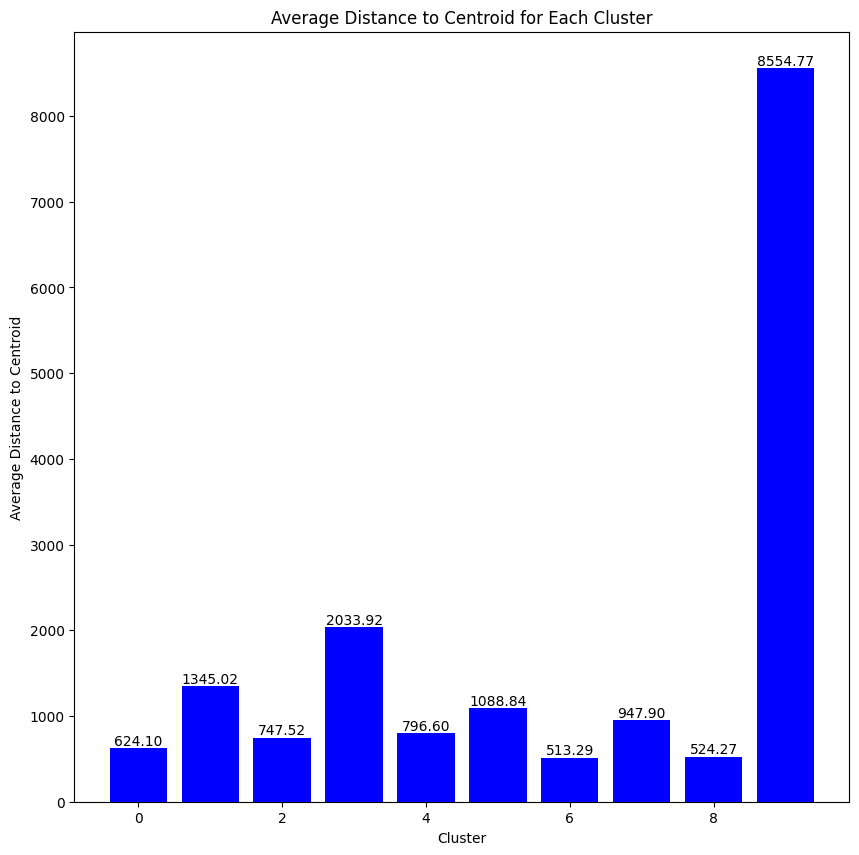

In [ ]:
# Initialize Spark session
spark = SparkSession.builder \
  .appName("KMeans Clustering") \
  .getOrCreate()

# Initialize KMeansVisualizer object
kmeans_visualizer = ClusteringWithKMeans(mnist_data_path,spark)
kmeans_visualizer.run()

# CÂU 2

In [ ]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix
import numpy as np
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import DenseVector
from pyspark.mllib.linalg import DenseMatrix
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
from pyspark.mllib.linalg import Matrices

- U là ma trận hướng phụ của A (left singular vectors)
- Σ là ma trận đường chéo chứa các giá trị riêng (singular values)
- V^T là ma trận hướng chính của A (right singular vectors)
- A = U * Σ * V^T

In [ ]:
class DimensionalityReductionWithSVD:
  def __init__(self,filepath, spark = None, num_components = 3, datarandom = 100):
    self.spark = spark or SparkSession.builder.appName("SVD Dimensionality Reduction").getOrCreate()
    self.num_components = num_components
    self.datarandom = datarandom
    self.filepath = filepath

  def load_data_from_file(self, file_path):
      # Load data into DataFrame
      data = self.spark.read.csv(file_path, header=False, inferSchema=True)
      num_columns = len(data.columns)
      # Rename columns dynamically
      columns = ["label"] + [f"pixel_{i}" for i in range(1, num_columns)]
      data = data.toDF(*columns)
      return data

  def preprocess_data(self, df):
      # Combine features into a single column
      assembler = VectorAssembler(inputCols=df.columns[1:], outputCol="features")
      df = assembler.transform(df).select("label", "features")
      scale=StandardScaler(inputCol='features',outputCol='standardized',withStd=True,
                      withMean=False)
      data_scale=scale.fit(df)
      data_scale_output=data_scale.transform(df).select("label", "standardized")

      return data_scale_output

  def load_Data(self, data):
    rows = data.rdd.map(lambda row: Vectors.dense(row.standardized))
    return rows


  def reduce_dimensionality_with_pca(self, data):
      pca = PCA(k=self.datarandom, inputCol="standardized", outputCol="pca_features")
      model = pca.fit(data)
      transformed = model.transform(data)
      return transformed

  def reduce_dimensionality_with_svd(self,data):
    mat = RowMatrix(data)

    svd = mat.computeSVD(self.num_components, computeU=True)
    U = svd.U       # The U factor is a RowMatrix.
    s = svd.s       # The singular values are stored in a local dense vector.
    V = svd.V       # The V factor is a local dense matrix.


    # Convert u to diagonal matrix Σ:
    # Σ = DenseMatrix(len(s), len(s), np.diag(s).ravel("F"))
    Σ = Matrices.diag(s)
    # Transpose V, convert to column major and then convert back to DenseMatrix
    V_ = DenseMatrix(V.numCols, V.numRows, V.toArray().transpose().ravel("F"))

    # Multiply:
    mat_ = U.multiply(Σ).multiply(V_)
    reduced_data = mat.multiply(mat_)
    print(reduced_data.take(2))
    return reduced_data


  def plot_3d_scatter_with_clustering(self, reduced_data, avg_distances):
    # Select random 100 data points after dimensionality reduction
    sample = reduced_data.select("pca_features", "label").sample(False, 0.01, seed=1).collect()

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Define a color map for clusters
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']

    # Plotting the points
    for point in sample:
        # Extract the first three PCA components
        x, y, z = point.pca_features[:3]
        cluster_id = avg_distances.filter(avg_distances.label == point.label).select("prediction").collect()[0].prediction
        ax.scatter(x, y, z, c=colors[cluster_id % len(colors)], marker='o')

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Scatter Plot after Dimensionality Reduction with Clustering')
    # Add colorbar
    norm = Normalize(vmin=0, vmax=len(colors)-1)
    sm = cm.ScalarMappable(cmap=cm.viridis, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ticks=range(len(colors)))
    cbar.set_label('Cluster ID')
    plt.show()


  def run(self):
    data = self.load_data_from_file(self.filepath)
    preprocess_data = self.preprocess_data(data)
    data_reduced = self.reduce_dimensionality_with_pca(preprocess_data)

    load_Data = self.load_Data(preprocess_data)
    # self.reduce_dimensionality_with_svd(load_Data)

    kmeans_visualizer = ClusteringWithKMeans(self.filepath, None)
    data_weight = kmeans_visualizer.weight_data(preprocess_data)
    predictions, model = kmeans_visualizer.Handle_KMeans(data_weight)


    self.plot_3d_scatter_with_clustering(data_reduced, predictions)


<ipython-input-14-64f26dc3b07b>:87: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=range(len(colors)))


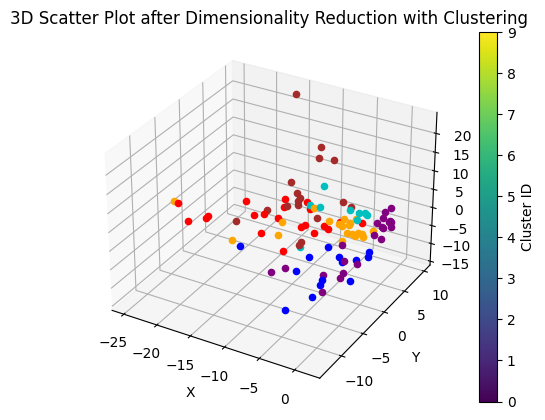

In [ ]:

# Initialize Spark session
spark2 = SparkSession.builder \
    .appName("SVD Dimensionality Reduction1") \
    .getOrCreate()
# Initialize KMeansVisualizer and DimensionalityReducer objects
reducer = DimensionalityReductionWithSVD(mnist_data_path,spark2)
reducer.run()

# CÂU 3

In [ ]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.ml.evaluation import RegressionEvaluator
# from recommenders.evaluation.spark_evaluation import SparkRankingEvaluation, SparkRatingEvaluation
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row


# Assigning global variables:
USER_COL = "user"
ITEM_COL = "item"
RATING_COL = "rating"
PREDICT_COL = "prediction"
REC_QUANTITY = 5

class CollaborativeFiltering:
  def __init__(self,filepath, spark = None,train_ratio = 0.7,min_similar_users= 10, max_similar_users = 20):
    self.spark = spark or SparkSession.builder.appName("Collaborative Filtering").getOrCreate()
    self.max_similar_users = max_similar_users
    self.min_similar_users = min_similar_users
    self.filepath = filepath
    self.train_ratio = train_ratio
    self.data = None
    self.train_data = None
    self.test_data = None
    self.model = None
    self.mse_values = []


  def load(self):
    self.data = self.spark.read.csv(self.filepath, header=True, inferSchema=True)
    return self.data

  def split_data(self):
    self.train_data, self.test_data = self.data.randomSplit([self.train_ratio, 1 - self.train_ratio], seed=42)



  def model_als(self, num_similar_users, evaluator_):

    training = self.train_data
    test = self.test_data
    als = ALS(
          userCol=    USER_COL,
          itemCol=    ITEM_COL,
          ratingCol=  RATING_COL,
          coldStartStrategy="drop"
          , implicitPrefs=True
          , nonnegative = True)

    #Tune the model
    param_grid = ParamGridBuilder()\
                  .addGrid(als.rank, [18,19,20])\
                  .addGrid(als.maxIter,[8,9,10])\
                  .addGrid(als.regParam ,[.1,.11,.12])\
                  .build()

    #define evaluator
    evaluator = evaluator_
    #build cross valiadation
    cv = CrossValidator(estimator=als,
                                estimatorParamMaps=param_grid,
                                evaluator=evaluator,
                                numFolds=3)
    model = cv.fit(training)
    best_model = model.bestModel
    return best_model


  def evaluator_als(self, model,evaluator_):
    test = self.test_data
    predictions = model.transform(test)
    evaluator = evaluator_
    rmse = evaluator.evaluate(predictions)
    return rmse

  def run_evaluation(self):
    evaluator_  = RegressionEvaluator(metricName = "mse",labelCol="rating", predictionCol ="prediction")
    for num_similar_users in range(self.min_similar_users, self.max_similar_users + 1):
      model = self.model_als(num_similar_users, evaluator_)
      mse = self.evaluator_als(model, evaluator_)
      self.mse_values.append((num_similar_users, mse))
    print(self.mse_values)
    return self.mse_values

  def get_recommendation(self,model):
    print("Generate top 10 product recommendations for each user")
    userRecs = model.recommendForAllUsers(10)
    userRecs.show()
    for it in userRecs.first():
      print(it)

    print("Generate top 10 user recommendations for each product")
    movieRecs = model.recommendForAllItems(10)
    movieRecs.show()
    for it in movieRecs.first():
      print(it)

  def get_recommendation_for_user(self,model, userid):
    user_df = self.spark.createDataFrame([(userid,)], ["user"])
    recommendations = model.recommendForUserSubset(user_df, 10)
    df_exploded = recommendations.select("user", explode("recommendations").alias("rec"))

    # Extract item and rating from the exploded struct
    result_df = df_exploded.select("user", "rec.item", "rec.rating")
    print("Item recommended for user:"+str(userid))
    result_df.show()
  def plot_mse(self):
      num_similar_users, mse = zip(*self.mse_values)
      bars = plt.bar(num_similar_users, mse, color='skyblue')
      plt.xlabel('Rank')
      plt.ylabel('Mean Squared Error (MSE)')
      plt.title('MSE for Different num_similar_users')
      for bar, value in zip(bars, mse):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, round(value, 2), ha='center', va='bottom')
      plt.show()

  def run(self):
    self.load()
    self.split_data()
    self.run_evaluation()
    self.plot_mse()


[(10, 11.984732393391914), (11, 12.013301120507661), (12, 12.0799172442757), (13, 12.031692908382242), (14, 12.048412101963336), (15, 12.066184928569943), (16, 12.180687676295506), (17, 12.03551303475902), (18, 12.006452403086575), (19, 11.977162790433148), (20, 12.011864485810191)]


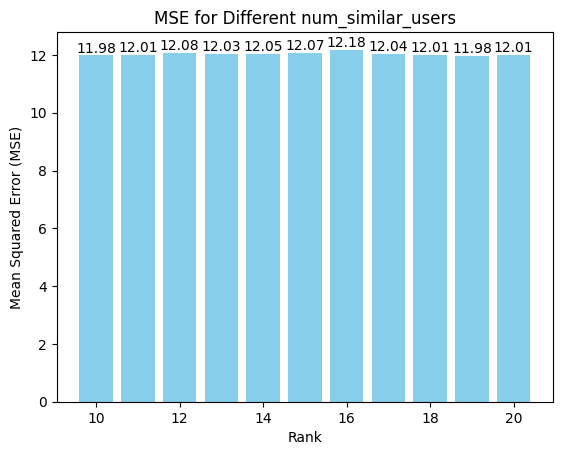

In [ ]:
cf = CollaborativeFiltering(rating_data_path,None)
cf.run()
# Generate recommendations for a specific user (for example, user with ID 1)
model = cf.model_als(10, RegressionEvaluator(metricName="mse", labelCol="rating", predictionCol="prediction"))


In [ ]:
cf.get_recommendation(model)

Generate top 10 product recommendations for each user
+----+--------------------+
|user|     recommendations|
+----+--------------------+
|  31|[{144, 1.2096658}...|
|  53|[{288, 0.68268085...|
|  34|[{413, 0.76865244...|
|  28|[{301, 0.8248858}...|
|  26|[{67, 1.002072}, ...|
|  27|[{199, 0.85164565...|
|  12|[{161, 1.1711688}...|
|  22|[{216, 0.98830247...|
|  47|[{352, 1.4117258}...|
|   1|[{352, 0.47790924...|
|  13|[{67, 1.314889}, ...|
|   6|[{288, 0.98038435...|
|   3|[{144, 1.1325608}...|
|  20|[{199, 0.8634735}...|
|  40|[{36, 1.1063914},...|
|  57|[{272, 1.2274514}...|
|  54|[{324, 0.5590942}...|
|  48|[{79, 0.8957969},...|
|   5|[{57, 1.1863935},...|
|  19|[{216, 0.9810164}...|
+----+--------------------+
only showing top 20 rows

31
[Row(item=144, rating=1.2096657752990723), Row(item=288, rating=1.1370865106582642), Row(item=440, rating=1.1362674236297607), Row(item=432, rating=1.0876582860946655), Row(item=89, rating=1.0285755395889282), Row(item=437, rating=1.022039890289

In [ ]:
cf.get_recommendation_for_user(model, 10)

Item recommended for user:10
+----+----+---------+
|user|item|   rating|
+----+----+---------+
|  10|  36|4.8247795|
|  10|  28| 4.810625|
|  10| 288| 4.682422|
|  10| 144| 4.671493|
|  10| 437| 4.652779|
|  10| 163|4.5348096|
|  10| 397|4.4652114|
|  10|  39| 4.397133|
|  10| 324| 4.380786|
|  10| 376| 4.377784|
+----+----+---------+



# CÂU 4

In [ ]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import col, lag,to_date, array, when, collect_list
from pyspark.sql.window import Window
from pyspark.sql.types import ArrayType, IntegerType
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.evaluation import RegressionEvaluator
class StockPricePrediction:
    def __init__(self,filepath, spark=None):
        self.spark = spark or SparkSession.builder.appName("Collaborative Filtering").getOrCreate()
        self.filepath = filepath
        self.data = None
        self.feature_vector = None
        self.traindata  =None
        self.testdata  =None
        self.model  =None

    def load_data(self):
        self.data = self.spark.read.csv(self.filepath, header=True, inferSchema=True)
        return self.data

    def data_fluctuation(self):
      # SORT
      self.data = self.data.withColumn("Ngay", to_date("Ngay", "dd/MM/yyyy")).orderBy(col("Ngay"))
      window_spec = Window.orderBy(col("Ngay"))
      # TÍNH BIÊN ĐỘ
      self.data = self.data.withColumn("fluctuation", (col("HVN") - lag("HVN", 1).over(window_spec)) / lag("HVN", 1).over(window_spec))
      # FILL NGÀY ĐẦU TIÊN
      self.data = self.data.withColumn("fluctuation", when(col("fluctuation").isNull(), 0).otherwise(col("fluctuation")))
      # self.data.show()

    def create_feature_vector(self):

      # vector_window_spec = Window.orderBy(col("Ngay")).rowsBetween(-4, 0)
      # # Collect the fluctuation values of the past 5 days into an array
      # self.feature_vector = self.data.withColumn("VectorFluctuationOfLast5Day", collect_list("fluctuation").over(vector_window_spec))
      # self.feature_vector.show(truncate=False)


        vector_window_spec = Window.orderBy("Ngay").rowsBetween(-5, -1)

        # Định nghĩa hàm UDF để đảm bảo độ dài mảng là 5 và thêm 0 nếu thiếu
        def ensure_length_5(arr):
            if arr is None:
                arr = []
            arr = [0.0 if v is None else v for v in arr]
            while len(arr) < 5:
                arr.append(0.0)  # Chèn 0 vào đầu mảng
            return arr

        ensure_length_5_udf = F.udf(ensure_length_5, ArrayType(DoubleType()))

        self.feature_vector = self.data.withColumn("VectorFluctuationOfLast5Day",
                                   ensure_length_5_udf(collect_list("fluctuation").over(vector_window_spec)))
        # Chuyển đổi mảng thành vector
        def array_to_vector(arr):
            return Vectors.dense(arr)

        array_to_vector_udf = F.udf(array_to_vector, VectorUDT())

        self.feature_vector = self.feature_vector.withColumn("features",
                                   array_to_vector_udf(col("VectorFluctuationOfLast5Day")))

        # self.feature_vector.show(truncate=False)

    def split_train_test_data(self):
      self.traindata = self.feature_vector.filter((col("Ngay") >= "2022-01-01") & (col("Ngay") <= "2022-06-30"))
      # self.traindata.show(truncate=False)
      self.testdata = self.feature_vector.filter(col("Ngay") > "2022-06-30")
      # self.testdata.show(truncate=False)


    def train_model(self):
        # Initialize Linear Regression
        lr = LinearRegression(featuresCol="features", labelCol="fluctuation")

        # Define a grid of hyperparameters to search over
        param_grid = ParamGridBuilder() \
            .addGrid(lr.maxIter, [10, 20, 30]) \
            .addGrid(lr.regParam, [0.1, 0.01]) \
            .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
            .build()

        # Define an evaluator
        evaluator = RegressionEvaluator(labelCol="fluctuation", predictionCol="prediction", metricName="rmse")

        # Initialize CrossValidator
        crossval = CrossValidator(estimator=lr,
                                  estimatorParamMaps=param_grid,
                                  evaluator=evaluator,
                                  numFolds=3)  # 3-fold cross validation

        # Fit the CrossValidator to the data
        cv_model = crossval.fit(self.traindata)

        # Get the best model from CrossValidator
        best_model = cv_model.bestModel

        # Print the best parameters found by CrossValidator
        print("Best maxIter:", best_model.getMaxIter())
        print("Best regParam:", best_model.getRegParam())
        print("Best elasticNetParam:", best_model.getElasticNetParam())

        self.model = best_model
        return best_model


    def evaluate_model(self, data):
        # Đánh giá mô hình bằng Mean Squared Error
        evaluator = RegressionEvaluator(labelCol="fluctuation", predictionCol="prediction", metricName="mse")
        predict = self.model.transform(data)
        # Chuyển đổi DataFrame sang RDD và tính toán MSE
        def calculate_mse(predictions):
            pred_and_label = predictions.select("prediction", "fluctuation").rdd.map(lambda row: (row[0], row[1]))
            mse = pred_and_label.map(lambda x: (x[0] - x[1])**2).mean()
            return mse
        mse = evaluator.evaluate(predict)
        return mse


    def plot_results(self, train_mse, test_mse):
        mse_values = [train_mse, test_mse]
        labels = ['Training MSE', 'Test MSE']
        colors = ['blue', 'green']

        plt.figure(figsize=(8, 6))
        bars = plt.bar(labels, mse_values, color=colors)

        plt.xlabel('Dataset')
        plt.ylabel('Mean Squared Error')
        plt.title('MSE of Linear Regression Model on Training and Test Data')

        # Hiển thị giá trị MSE trên các cột
        for bar, value in zip(bars, mse_values):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - (bar.get_height() * 0.1),
                    f'{value:.4f}', ha='center', va='bottom', color='white', fontsize=12)

        plt.show()


    def run(self):
      self.load_data();
      self.data_fluctuation()
      self.create_feature_vector()
      self.split_train_test_data()
      self.train_model()
      train_mse = self.evaluate_model(self.traindata)
      test_mse = self.evaluate_model(self.testdata)
      print(train_mse,test_mse)
      self.plot_results(train_mse, test_mse)

Best maxIter: 10
Best regParam: 0.1
Best elasticNetParam: 0.0
0.0005941094446972082 0.0006269688924476776


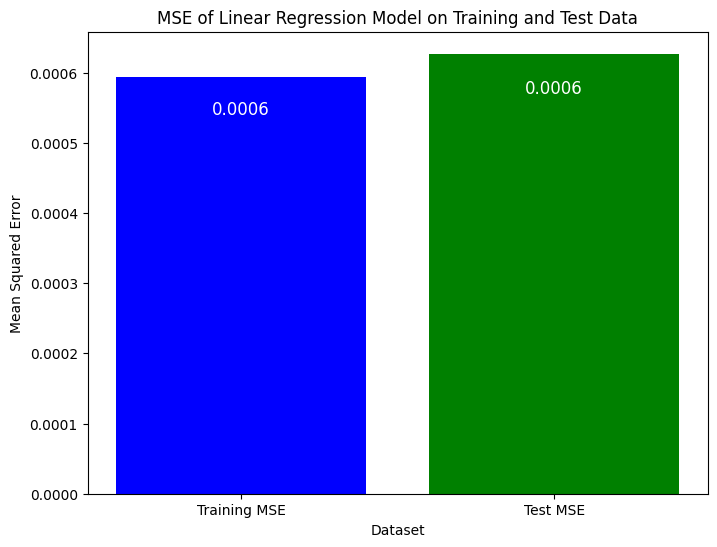

In [ ]:
StockPricePrediction = StockPricePrediction("/content/stockHVN2022.csv")
StockPricePrediction.run()

# CÂU 5

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier, RandomForestClassifier
from pyspark.ml.classification import LinearSVC, OneVsRest
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.types import DoubleType, IntegerType

class MNISTClassifier:
    def __init__(self, file_path, spark=None, train_ratio=0.7, k=10):
        self.spark = spark or SparkSession.builder.appName("MNIST Classifier").getOrCreate()
        self.train_ratio = train_ratio
        self.k = k
        self.lenvector = 0
        self.train_data = None
        self.test_data = None
        self.file_path = file_path
        self.trainDFBinary = None
        self.testDFBinary = None

    def load_data(self):
        # Load data into DataFrame
        data = self.spark.read.csv(self.file_path, header=False, inferSchema=True)
        num_columns = len(data.columns)
        self.lenvector = num_columns - 1
        # Rename columns dynamically
        columns = ["label"] + [f"pixel_{i}" for i in range(1, num_columns)]
        data = data.toDF(*columns)
        return data

    def preprocess_data(self, df):
        # Assemble the features
        feature_cols = [f"pixel_{i}" for i in range(1, len(df.columns))]
        assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

        df = assembler.transform(df)
        scaler = StandardScaler(inputCol='features', outputCol='standardized', withStd=True, withMean=False)
        data_scale = scaler.fit(df)
        data_scale_output = data_scale.transform(df)

        return data_scale_output.select("label", "standardized")

    def split_data(self, data):
        self.train_data, self.test_data = data.randomSplit([self.train_ratio, 1 - self.train_ratio],seed=42)
        return self.train_data, self.test_data

    def MLPC(self):
      layers = [self.lenvector, 256, 128, 10]
      classifier = MultilayerPerceptronClassifier(labelCol='label',
                                            featuresCol='standardized',
                                            maxIter=100,
                                            layers=layers,
                                            blockSize=128,
                                            seed=1234)
      pipeline = Pipeline(stages= [ classifier])
      model = pipeline.fit(self.train_data)
      return model

    def RFC(self):
      # Define the Random Forest classifier
      rf_classifier = RandomForestClassifier(labelCol="label", featuresCol="standardized")

      # Create a Pipeline
      pipeline = Pipeline(stages=[ rf_classifier])
      paramGrid = ParamGridBuilder() \
          .addGrid(rf_classifier.numTrees, [10, 20, 30]) \
          .addGrid(rf_classifier.maxDepth, [5, 10, 15]) \
          .build()

      # Create the cross-validator
      cross_validator = CrossValidator(estimator=pipeline,
                                estimatorParamMaps=paramGrid,
                                evaluator=MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy"),
                                numFolds=2, seed=42)

      # Train the model with the best hyperparameters
      cv_model = cross_validator.fit(self.train_data)
      return cv_model

    def LSVMV_1(self):
      # Phân loại nhị phân bằng SVM
      # SVM tiêu chuẩn là một bộ phân loại nhị phân
      # ì vậy, để bắt đầu làm việc với trình phân loại này,
      # chúng ta hãy chuyển đổi bài toán gốc nhiều lớp thành bài toán nhị phân bằng cách giải bài toán phân biệt các chữ số "3" với các chữ số "5"

      # User defined function to convert labels "3" and "5" to binary values "1" and "0"
      changeLabels = udf(lambda label: 1 if (label==3) else 0, IntegerType())

      # Create the training DF for the binary problem 3 vs. 5
      ## Select digits 3 and 5
      trainDFBinaryAux= self.train_data.filter((self.train_data.label==3) | (self.train_data.label==5))
      ## Convert labels to 0 and 1
      trainDFBinary = trainDFBinaryAux.select(changeLabels(self.train_data.label).alias('label'), col('standardized'))
      trainDFBinary = trainDFBinary.withColumnRenamed("standardized", "features")
      self.trainDFBinary = trainDFBinary
      # trainDFBinary.show(5)
      print('Number of traning samples %d' %trainDFBinary.count())

      # Create the test DF for the binary problem 3 vs. 5
      ## Select digits 3 and 5
      testDFBinaryAux = self.test_data.filter((self.test_data.label==3) | (self.test_data.label==5))
      ## Convert labels to 0 and 1
      testDFBinary = testDFBinaryAux.withColumn('label', (changeLabels(self.test_data.label)))
      testDFBinary = testDFBinary.withColumnRenamed("standardized", "features")
      self.testDFBinary = testDFBinary

      # testDFBinary.show(5)
      print('Number of test samples %d' %testDFBinary.count())

      # Define your classifier
      lsvc = LinearSVC(maxIter=10, regParam=0.1)

      # Fit the model
      lsvcModel = lsvc.fit(trainDFBinary)

      # Print the coefficients and intercept for linearsSVC
      coefficients = lsvcModel.coefficients
      intercept = lsvcModel.intercept
      print("Some coefficients: " + str(coefficients[250:300]))
      print("Intercept: " + str(intercept))

      # ===========================================================================================================================
      # Compute predictions for test data
      predictions = lsvcModel.transform(testDFBinary)

      # Show the computed predictions and compare with the original labels
      predictions.select("features", "label", "prediction").show(10)

      # Define the evaluator method with the corresponding metric and compute the classification error on test data
      evaluator = MulticlassClassificationEvaluator().setMetricName('accuracy')
      accuracy = evaluator.evaluate(predictions)

      # Show the accuracy
      print("Test accuracy = %g" % (accuracy))

      # ===========================================================================================================================
      # Compute predictions for training data
      predictions_train = lsvcModel.transform(trainDFBinary)

      # Show the computed predictions and compare with the original labels for training data
      predictions_train.select("features", "label", "prediction").show(10)

      # Define the evaluator method with the corresponding metric and compute the classification accuracy on training data
      evaluator_train = MulticlassClassificationEvaluator().setMetricName('accuracy')
      accuracy_train = evaluator_train.evaluate(predictions_train)
      print("Training accuracy = %g" % accuracy_train)

    def LSVMVC(self):
        # Define your binary classifier
        lsvc = LinearSVC()

        # Define the One Vs All Classifier.
        ovr = OneVsRest(classifier=lsvc)

        # Create a ParamGrid for tuning
        paramGrid = ParamGridBuilder() \
            .addGrid(lsvc.maxIter, [10, 20]) \
            .addGrid(lsvc.regParam, [0.1, 0.01]) \
            .build()

        # Define the evaluator
        evaluator = MulticlassClassificationEvaluator()

        # Create the cross-validator
        cross_validator = CrossValidator(estimator=ovr,
                                        estimatorParamMaps=paramGrid,
                                        evaluator=evaluator,
                                        numFolds=2)

        # Train the model
        dataDF = self.train_data.withColumnRenamed("standardized", "features")
        cvModel = cross_validator.fit(dataDF)

        # Score the model on test data
        dataTestDF = self.test_data.withColumnRenamed("standardized", "features")

        return cvModel, dataDF, dataTestDF


    def calculate_accuracy(self,model, train_data, test_data):
      evaluator = MulticlassClassificationEvaluator().setMetricName('accuracy')
      # Tính độ chính xác trên tập huấn luyện
      train_predictions = model.transform(train_data)
      train_accuracy = evaluator.evaluate(train_predictions)

      # Tính độ chính xác trên tập kiểm tra
      test_predictions = model.transform(test_data)
      test_accuracy = evaluator.evaluate(test_predictions)

      return train_accuracy, test_accuracy

    def plot_accuracy(self,train_accuracies, test_accuracies, model_names):
        x = range(len(model_names))
        width = 0.35

        fig, ax = plt.subplots()
        train_bar = ax.bar(x, train_accuracies, width, label='Train Accuracy')
        test_bar = ax.bar([p + width for p in x], test_accuracies, width, label='Test Accuracy')

        ax.set_ylabel('Accuracy')
        ax.set_title('Model Accuracy Comparison')
        ax.set_xticks([p + width / 2 for p in x])
        ax.set_xticklabels(model_names)
        ax.legend()

        plt.show()
    def run(self):
        data = self.load_data()
        data_preprocess = self.preprocess_data(data)

        train, test = self.split_data(data_preprocess)
        mlpc_model  = self.MLPC()
        rfc_model  = self.RFC()
        lsvm_model, train, test  = self.LSVMVC()
        # Đánh giá độ chính xác của mỗi mô hình trên tập huấn luyện và tập kiểm tra
        mlpc_train_accuracy, mlpc_test_accuracy = self.calculate_accuracy(mlpc_model, self.train_data, self.test_data)
        print(mlpc_train_accuracy, mlpc_test_accuracy)

        rfc_train_accuracy, rfc_test_accuracy = self.calculate_accuracy(rfc_model, self.train_data, self.test_data)
        print(rfc_train_accuracy, rfc_test_accuracy)

        lsvm_train_accuracy, lsvm_test_accuracy = self.calculate_accuracy(lsvm_model, train, test)
        print(lsvm_train_accuracy, lsvm_test_accuracy)


        # Vẽ biểu đồ
        model_names = ['MLPC', 'RFC', 'LSVMV']
        train_accuracies = [mlpc_train_accuracy, rfc_train_accuracy, lsvm_train_accuracy]
        test_accuracies = [mlpc_test_accuracy, rfc_test_accuracy, lsvm_test_accuracy]

        self.plot_accuracy(train_accuracies, test_accuracies, model_names)

        self.LSVMV_1()

1.0 0.9383139136394791
0.9995763908500424 0.9427690198766279
0.9162665913583733 0.8947909527073338


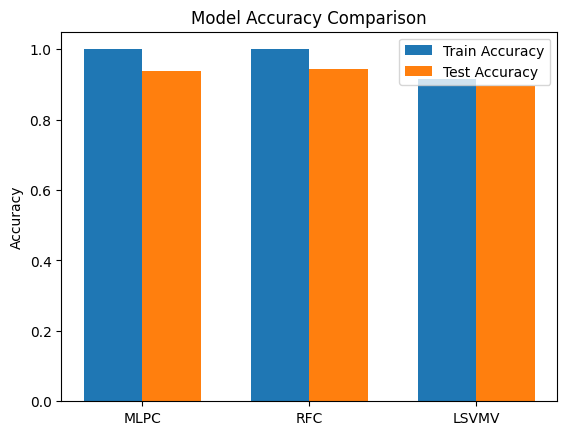

Number of traning samples 1342
Number of test samples 560
Some coefficients: [-0.00689122  0.          0.          0.          0.00112437  0.01119146
  0.02279705  0.01378714  0.01214601  0.00390054 -0.01830037 -0.04694357
 -0.06339717 -0.06156863 -0.04491811 -0.02529314 -0.00250607  0.03852272
  0.05093389  0.05955461  0.04156827  0.02901068  0.01536156 -0.01229214
 -0.0268905  -0.04352179 -0.02990972 -0.01784915 -0.00645343 -0.00841089
  0.          0.          0.0048039   0.0172262   0.02472099  0.01561171
  0.01019714 -0.01012406 -0.05406392 -0.09357186 -0.10697088 -0.08018087
 -0.05007008 -0.01592355  0.02282737  0.05048352  0.06248532  0.06560798
  0.0550032   0.04423839]
Intercept: -0.003969869405237277
+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|(784,[91,92,93,94...|    1|       1.0|
|(784,[92,93,94,95...|    1|       1.0|
|(784,[93,94,95,96...|    1|       1.0|
|(784,[93,94,95,96...|    1|       1.0|


In [ ]:
# Example usage:
mnist_classifier = MNISTClassifier("/content/mnist_mini.csv")
mnist_classifier.run()

In [3]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pandoc is already the newest version (2.9.2.1-3ubuntu2).
pandoc set to manually installed.
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  fonts-urw-base35 libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0 libkpathsea6
  libpdfbox-java libptexenc1 libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1
  libzzip-0-13 lmodern poppler-data preview-latex-style rake ruby ruby-net-telnet ruby-rubygems
  ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils teckit tex-common tex-gyre
  texlive-base texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fo

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!cp /content/drive/MyDrive/Colab Notebooks

cp: cannot stat '/content/drive/MyDrive/Colab': No such file or directory


In [6]:
!jupyter nbconvert --to PDF "/content/drive/MyDrive/Colab Notebooks/source.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/source.ipynb to PDF
[NbConvertApp] Support files will be in source_files/
[NbConvertApp] Making directory ./source_files
[NbConvertApp] Making directory ./source_files
[NbConvertApp] Making directory ./source_files
[NbConvertApp] Making directory ./source_files
[NbConvertApp] Making directory ./source_files
[NbConvertApp] Writing 156398 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 282080 bytes to /content/drive/MyDrive/Colab Notebooks/source.pdf
